<a href="https://colab.research.google.com/github/sorennelson/MediaRecommendation/blob/v2-recsys/MovieRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data: MovieLens 25M Dataset - https://grouplens.org/datasets/movielens/25m/

# Final Model:
# Final Results

# Resources: 
  # https://paperswithcode.com/dataset/movielens
  # https://developer.nvidia.com/nvidia-merlin

In [1]:
!pip install nvtabular
!pip install merlin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.2/301.2 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 KB 14.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 KB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.1/934.1 KB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.4/232.4 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.8/237.8 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 111.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.6/405.6 KB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/8

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import nvtabular as nvt
from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader
from merlin.schema.tags import Tags

In [3]:
MOVIE_PATH = "/content/drive/MyDrive/Colab Notebooks/Personal/MediaRec/ml-25m"

# Preprocessing
Skip to Data Loading if transformed datasets are already saved.

In [ ]:
df_movies = pd.read_csv(os.path.join(MOVIE_PATH, 'movie_features.csv'))
df_movies.head(n=5)

,Unnamed: 0,Unnamed: 0.1,movieId,title,genres,split_genres,lm_genres,num_ratings,avg_rating
0,0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"['Adventure', 'Animation', 'Children', 'Comedy...",[-7.62170404e-02 -7.34341815e-02 3.21774840e-...,57309.0,3.893708
1,1,1,2,Jumanji (1995),Adventure|Children|Fantasy,"['Adventure', 'Children', 'Fantasy']",[-2.23115534e-01 -3.53449345e-01 1.68107659e-...,24228.0,3.251527
2,2,2,3,Grumpier Old Men (1995),Comedy|Romance,"['Comedy', 'Romance']",[-1.22938655e-01 -1.07958302e-01 2.52478123e-...,11804.0,3.142028
3,3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"['Comedy', 'Drama', 'Romance']",[ 2.22296063e-02 -2.31470495e-01 2.30256513e-...,2523.0,2.853547
4,4,4,5,Father of the Bride Part II (1995),Comedy,['Comedy'],[-1.98312491e-01 -2.89419562e-01 2.86418885e-...,11714.0,3.058434


In [ ]:
def get_ratings_df(popular_workflow:bool = True, movie_popular_workflow:bool = False) -> pd.DataFrame:
    '''

    TODO: Needs to be updated later on but want a bias toward more popular media to start.

    Args:
      popular_workflow: Remove users with < 50 ratings and movies with < 15 ratings
      movie_popular_workflow: Remove movies with < 5 ratings. Only applied if popular_workflow=False.
    '''

    df_ratings = pd.read_csv(os.path.join(MOVIE_PATH, 'ratings.csv'))
    df_ratings = df_ratings.drop(columns=['timestamp'])

    if popular_workflow:
        unique_usercount = df_ratings.groupby('userId')['movieId'].nunique()
        unique_moviecount = df_ratings.groupby('movieId')['userId'].nunique()
        print('Number of users with 50 ratings or more: {} / {}'.format(
            len(unique_usercount[unique_usercount >= 50]), len(np.unique(df_ratings['userId'])))
        )
        print('Number of movies with 15 ratings or more: {} / {}'.format(
            np.sum(unique_moviecount >= 15), np.sum(unique_moviecount > 0))
        )
        df_ratings = df_ratings[df_ratings['userId'].isin(list(unique_usercount[unique_usercount >= 50].index))]
        df_ratings = df_ratings[df_ratings['movieId'].isin(list(unique_moviecount[unique_moviecount >= 15].index))]

    elif movie_popular_workflow:
        unique_moviecount = df_ratings.groupby('movieId')['userId'].nunique()
        print('Number of movies with 5 ratings or more: {} / {}'.format(
            np.sum(unique_moviecount >= 5), np.sum(unique_moviecount > 0))
        )
        df_ratings = df_ratings[df_ratings['movieId'].isin(list(unique_moviecount[unique_moviecount >= 5].index))]

    return df_ratings

In [ ]:
df_ratings = get_ratings_df()
df_ratings.head(n=5)

102492 162541
20590 59047


In [ ]:
# Look at the raw distribution of user ratings
np.histogram(df_ratings.groupby('userId')['movieId'].nunique(), bins=20)

(array([161824,    614,     84,     11,      5,      2,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      1]),
 array([2.00000e+01, 1.62910e+03, 3.23820e+03, 4.84730e+03, 6.45640e+03,
        8.06550e+03, 9.67460e+03, 1.12837e+04, 1.28928e+04, 1.45019e+04,
        1.61110e+04, 1.77201e+04, 1.93292e+04, 2.09383e+04, 2.25474e+04,
        2.41565e+04, 2.57656e+04, 2.73747e+04, 2.89838e+04, 3.05929e+04,
        3.22020e+04]))

In [ ]:
# Look at the raw distribution of movie ratings
np.histogram(df_ratings.groupby('movieId')['userId'].nunique(), bins=20)

(array([31254,   712,   312,   163,    84,    57,    39,    26,    19,
           14,    10,     5,     7,     5,     6,     1,     1,     1,
            1,     3]),
 array([5.00000e+00, 4.07930e+03, 8.15360e+03, 1.22279e+04, 1.63022e+04,
        2.03765e+04, 2.44508e+04, 2.85251e+04, 3.25994e+04, 3.66737e+04,
        4.07480e+04, 4.48223e+04, 4.88966e+04, 5.29709e+04, 5.70452e+04,
        6.11195e+04, 6.51938e+04, 6.92681e+04, 7.33424e+04, 7.74167e+04,
        8.14910e+04]))

In [ ]:
# Split into train/val/test 

# In val/test we want clean (untrained on) users and unclean (trained on but not those ratings) users 
# unclean percentages are out of ratings
# clean percentages are out of users
p_test_unclean, p_test_clean = 0.075, 0.025
p_val_unclean, p_val_clean = 0.075, 0.025

# Grab clean users for val/test
users = np.unique(df_ratings['userId'])
users_clean_val = users[-int(len(users)*p_val_clean):]
users_clean_test = users[-int(len(users)*(p_test_clean+p_val_clean)):-int(len(users)*p_val_clean)]
users_unclean = users[:-int(len(users)*(p_test_clean+p_val_clean))]

df_clean_val = df_ratings[df_ratings['userId'].isin(users_clean_val)]
df_clean_test = df_ratings[df_ratings['userId'].isin(users_clean_test)]
unclean = df_ratings[df_ratings['userId'].isin(users_unclean)]

# Grab unclean users
unclean_rating_idxs = np.random.permutation(len(unclean))
unclean_rating_idxs_train = unclean_rating_idxs[:-int((p_test_unclean+p_val_unclean)*len(unclean_rating_idxs))]
unclean_rating_idxs_val = unclean_rating_idxs[-int(p_val_unclean*len(unclean_rating_idxs)):]
unclean_rating_idxs_test = unclean_rating_idxs[-int((p_test_unclean+p_val_unclean)*len(unclean_rating_idxs)): 
                                               -int(p_val_unclean*len(unclean_rating_idxs))]

df_train = unclean.iloc[unclean_rating_idxs_train]
df_val = unclean.iloc[unclean_rating_idxs_val]
df_test = unclean.iloc[unclean_rating_idxs_test]


In [ ]:
# Check clean users
print(len(users_unclean), len(users_clean_val), len(users_clean_test))
assert np.sum(np.in1d(users_unclean, users_clean_val)) == 0
assert np.sum(np.in1d(users_unclean, users_clean_test)) == 0
print(len(df_clean_val), len(df_clean_test))

# Check unclean
print(len(unclean_rating_idxs_train), len(unclean_rating_idxs_val), len(unclean_rating_idxs_test))
assert np.sum(np.in1d(unclean_rating_idxs_train, unclean_rating_idxs_val)) == 0
assert np.sum(np.in1d(unclean_rating_idxs_train, unclean_rating_idxs_test)) == 0

# Check unclean users
print(len(df_train), len(df_val), len(df_test))

154414 4063 4064
610426 616912
20206844 1782956 1782957
20206844 1782956 1782957


In [ ]:
def get_workflow(load_path:str = None) -> nvt.Workflow:
    ''' Loads the Workflow or creates a new one if load_path is None.'''
    if load_path:
        workflow = nvt.Workflow.load(load_path)

    else:
        # Categorify id's to ensure continuous inputs
        output = ['userId', 'movieId'] >> nvt.ops.Categorify()
        output += nvt.ColumnGroup(["rating"]) >> nvt.ops.NormalizeMinMax()
        workflow = nvt.Workflow(output)

    return workflow

In [ ]:
!unzip movie_workflow_popular.zip
workflow_path = 'movie_workflow_popular'
workflow = get_workflow(workflow_path)

In [ ]:
workflow.output_schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension
0,userId,(Tags.CATEGORICAL),int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.userId.parquet,0.0,160916.0,userId,160917.0,512.0
1,movieId,(Tags.CATEGORICAL),int64,False,False,NaN,0.0,0.0,0.0,.//categories/unique.movieId.parquet,0.0,57249.0,movieId,57250.0,512.0
2,rating,(Tags.CONTINUOUS),float64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Save and zip workflow
workflow.save('movie_workflow_popular')
!zip -r movie_workflow_popular movie_workflow_popular


# Data Loading
Start from here if transformed datasets are already saved.

In [ ]:
def partition_fit_and_transform():
    # Train file is too large so we partition into 10 datasets to fit
    for i in range(10):
        if i < 9:
            ds = nvt.Dataset(df_train.iloc[i*(len(df_train)//10):(i+1)*(len(df_train)//10)])
        else:
            ds = nvt.Dataset(df_train.iloc[i*(len(df_train)//10):])
        workflow.fit(ds)
    
    # Train file is too large so we partition into 10 datasets to transform
    for i in range(10):
        if i < 9:
            ds = nvt.Dataset(df_train.iloc[i*(len(df_train)//10):(i+1)*(len(df_train)//10)])
        else:
            ds = nvt.Dataset(df_train.iloc[i*(len(df_train)//10):])
        workflow.transform(ds).to_parquet('train_{}'.format(i))

    # Transform val/test
    workflow.transform(nvt.Dataset(df_val)).to_parquet('val')
    workflow.transform(nvt.Dataset(df_test)).to_parquet('test')

In [ ]:
# Load in our transformed datasets and convert to torch-ready
def load_dls(batch_size):
    train_dls = []
    for i in range(10):
        train_torch = TorchAsyncItr(
            nvt.Dataset('train_{}'.format(i), engine='parquet'),
            batch_size=batch_size,
            cats=['userId', 'movieId', 'split_genres'],
            conts=["rating", 'avg_rating', 'num_ratings'], 
        )
        train_dl = DLDataLoader(
            train_torch, batch_size=None, pin_memory=False, num_workers=0
        )
        train_dls.append(train_dl)


    val_torch = TorchAsyncItr(
        nvt.Dataset('val', engine='parquet'),
        batch_size=batch_size,
        cats=['userId', 'movieId', 'split_genres'],
        conts=["rating", 'avg_rating', 'num_ratings'], 
    )
    val_dl = DLDataLoader(
        val_torch, batch_size=None, pin_memory=False, num_workers=0
    )

    test_torch = TorchAsyncItr(
        nvt.Dataset('test', engine='parquet'),
        batch_size=batch_size,
        cats=['userId', 'movieId', 'split_genres'],
        conts=["rating", 'avg_rating', 'num_ratings'], 
    )
    test_dl = DLDataLoader(
        test_torch, batch_size=None, pin_memory=False, num_workers=0
    )
    return train_dls, val_dl, test_dl


# Models

In [ ]:
class VanillaCF(nn.Module):
    def __init__(self, emb_size, n_users=97369, n_media=20591):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.media_emb = nn.Embedding(n_media, emb_size)

    def forward(self, user, media):
        return torch.sigmoid(self.user_emb(user) @ torch.transpose(self.media_emb(media), 1, 2))


class MLP(nn.Module):
    def __init__(self, emb_size, hidden_dim, n_users=154415, n_media=56961):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.media_emb = nn.Embedding(n_media, emb_size)

        self.mlp = nn.Sequential(nn.Linear(emb_size*2, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.Linear(hidden_dim, 1))

    def forward(self, user, media):
        x = torch.cat([self.user_emb(user).transpose(1, 2), self.media_emb(media).transpose(1, 2)], axis=1).squeeze()
        return torch.sigmoid(self.mlp(x))
        

class CFMLP(nn.Module):
    def __init__(self, emb_size, hidden_dim, n_users=154415, n_media=56961):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.media_emb = nn.Embedding(n_media, emb_size)

        self.mlp = nn.Sequential(nn.Linear(emb_size, hidden_dim),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(hidden_dim, hidden_dim),
                                 nn.LayerNorm(hidden_dim),
                                 nn.Linear(hidden_dim, 1))

    def forward(self, user, media):
        x = self.user_emb(user) * self.media_emb(media)
        return self.mlp(x)


def get_params(no_decay=[]):
  no_decay_params, decay_params = [], []
  for name, param in model.named_parameters():

    decay_param = True
    for s in no_decay:
      if s in name:
        no_decay_params.append(param)
        decay_param = False
        break

    if decay_param:
      decay_params.append(param)

  return [{'params': no_decay_params, 'weight_decay': 0}, {'params': decay_params}]

# Training

In [ ]:
def train_model(train_dls, val_dl, test_dl, model, loss_fn, opt):
    metrics = []

    for epoch in range(epochs):
        start = time.time()

        mse, rmse = train(train_dls, model, loss_fn, opt, epoch+1)
        val_mse, val_rmse = validate(val_dl, model, loss_fn, epoch+1)

        metrics.append([mse, rmse, val_mse, val_rmse])
        print('Epoch {}/{} - completed {}M - est. remaining {}H {}M \n'.format(
                                                            epoch+1, epochs, 
                                                            int((time.time()-start) // 60), 
                                                            int((time.time()-start) // 60 * (epochs - epoch-1) // 60),
                                                            int((time.time()-start) // 60 * (epochs - epoch-1) % 60)
                                                            ))
    
    return metrics

In [ ]:
def train(train_dls, model, loss_fn, opt, epoch):
    losses = []
    n_examples = 0
    model.cuda()
    
    model.train()

    for i, train_dl in enumerate(train_dls):
        for j, (x, _) in enumerate(train_dl):
            user = x['userId'].to('cuda')
            media = x['movieId'].to('cuda')
            y = x['rating'].to('cuda')

            pred = model(user, media)
            pred = pred.squeeze()

            loss = loss_fn(pred, y)
            
            opt.zero_grad()
            loss.backward()
            opt.step()

            losses += [loss.detach()*len(y)]
            n_examples += len(y)

        if (i+1) % 5 == 0:
            print('Train: Epoch {} - dl {}/{} - loss {:.3f} - rmse {:.3f}'.format(
                                                                    epoch, i, len(train_dls),
                                                                    torch.tensor(losses).sum()/n_examples, 
                                                                    (torch.tensor(losses).sum()/n_examples).sqrt()))

    return torch.tensor(losses).sum()/n_examples, (torch.tensor(losses).sum()/n_examples).sqrt()


def validate(val_dl, model, loss_fn, epoch):
    losses = []
    n_examples = 0
    model.cuda()
    model.eval()

    for i, (x, _) in enumerate(val_dl):
        user = x['userId'].to('cuda')
        media = x['movieId'].to('cuda')
        y = x['rating'].to('cuda')

        with torch.no_grad():
            pred = model(user, media)
            pred = pred.squeeze()

            loss = loss_fn(pred, y)

        losses += [loss*len(y)]
        n_examples += len(y)

    print('Eval: Epoch {} - loss {:.3f} - rmse {:.3f}'.format(
                                                      epoch,
                                                      torch.tensor(losses).sum()/n_examples, 
                                                      (torch.tensor(losses).sum()/n_examples).sqrt()))

    return torch.tensor(losses).sum()/n_examples, (torch.tensor(losses).sum()/n_examples).sqrt()

In [ ]:
def plot(train, val, metric='loss'):        
    epochs = range(1, len(train) + 1)

    plt.plot(epochs, train, 'k', label='Train ' + metric)
    plt.plot(epochs, train, 'b', label='Validation ' + metric)
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

## Vanilla Collaborative Filtering

In [ ]:
emb_size = 512
model = VanillaCF(emb_size)
batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-3
decay = 5e-5
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

In [ ]:
# Normalize + sigmoid
emb_size = 12
model = VanillaCF(emb_size)
batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Train: Epoch 1 - dl 4/10 - loss 0.118 - rmse 0.344
Train: Epoch 1 - dl 9/10 - loss 0.082 - rmse 0.286
Eval: Epoch 1 - loss 0.041 - rmse 0.204
Epoch 1/5 - completed 0M - est. remaining 0H 0M 

Train: Epoch 2 - dl 4/10 - loss 0.039 - rmse 0.197
Train: Epoch 2 - dl 9/10 - loss 0.038 - rmse 0.195
Eval: Epoch 2 - loss 0.038 - rmse 0.194
Epoch 2/5 - completed 0M - est. remaining 0H 0M 

Train: Epoch 3 - dl 4/10 - loss 0.036 - rmse 0.189
Train: Epoch 3 - dl 9/10 - loss 0.035 - rmse 0.187
Eval: Epoch 3 - loss 0.036 - rmse 0.190
Epoch 3/5 - completed 0M - est. remaining 0H 0M 

Train: Epoch 4 - dl 4/10 - loss 0.033 - rmse 0.183
Train: Epoch 4 - dl 9/10 - loss 0.033 - rmse 0.182
Eval: Epoch 4 - loss 0.035 - rmse 0.188
Epoch 4/5 - completed 0M - est. remaining 0H 0M 

Train: Epoch 5 - dl 4/10 - loss 0.032 - rmse 0.179
Train: Epoch 5 - dl 9/10 - loss 0.032 - rmse 0.178
Eval: Epoch 5 - loss 0.035 - rmse 0.186
Epoch 5/5 - completed 0M - est. remaining 0H 0M 



[[tensor(0.0816), tensor(0.2857), tensor(0.0415), tensor(0.2037)],
 [tensor(0.0379), tensor(0.1948), tensor(0.0375), tensor(0.1937)],
 [tensor(0.0351), tensor(0.1873), tensor(0.0362), tensor(0.1903)],
 [tensor(0.0331), tensor(0.1819), tensor(0.0352), tensor(0.1877)],
 [tensor(0.0316), tensor(0.1778), tensor(0.0347), tensor(0.1862)]]

### Vanilla CF Test

In [ ]:
# Extract user (not necessary but it works)
# model = VanillaCF(emb_size=12)
# model.load_state_dict(torch.load('CF-test.pt'))
model = torch.jit.load('cf_12emb_1e-2lradam_0d_5e_prodavg-0--01_23_25.pt')
# user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), 0, 0)[1:]
# test_model = ProdVanillaCF(user_emb, model.media_emb.weight.detach())
loss_fn = nn.MSELoss()
validate(dl, model, loss_fn, -1)


tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
Eval: Epoch -1 - loss 0.159 - rmse 0.399


(tensor(0.1590), tensor(0.3988))

In [ ]:
# Gather top predictions for the model - use with same user

preds = []

model.cuda()
model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    y = x['rating'].to('cuda')

    with torch.no_grad():
        pred = model(user, media)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:2])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9639), 193972), (tensor(0.9548), 191219)]


### Vanilla CF Default Embedding

In [ ]:
model = torch.jit.load('cf_12emb_1e-2lradam_0d_5e--01_23_23.pt')

In [ ]:
def get_test_clean_dl(batch_size):
    workflow.transform(nvt.Dataset(df_clean_test)).to_parquet('test_clean')

    test_clean_torch = TorchAsyncItr(
        nvt.Dataset('test_clean', engine='parquet'),
        batch_size=batch_size,
        cats=['userId', 'movieId'],
        conts=["rating"], 
    )
    test_clean_dl = DLDataLoader(
        test_clean_torch, batch_size=None, pin_memory=False, num_workers=0
    )
    return test_clean_dl

In [ ]:
batch_size = 8192
# Clean DL will return 0 for all users not in train set, used for default embedding indexing
test_clean_dl = get_test_clean_dl(batch_size)

# Create a model with the default embedding
default_user_emb = extract_prod_user_emb(model.user_emb.weight, None)
test_model = ProdVanillaCF(default_user_emb, model.media_emb.weight)
loss_fn = nn.MSELoss()

validate(test_clean_dl, test_model, loss_fn, -1)
print(default_user_emb)

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Eval: Epoch -1 - loss 0.061 - rmse 0.246
tensor([[ 0.6119, -0.2610,  0.0553,  0.0755,  0.2839,  0.3865, -0.4928, -0.3124,
         -0.5280, -0.4311,  0.7406, -0.8080]], grad_fn=<MeanBackward1>)


In [ ]:
# Compare against random embedding
for _ in range(5):
  rand_user_emb = torch.rand(default_user_emb.shape)
  test_model = ProdVanillaCF(rand_user_emb, model.media_emb.weight)
  loss_fn = nn.MSELoss()

  validate(test_clean_dl, test_model, loss_fn, -1)

print(rand_user_emb)

Eval: Epoch -1 - loss 0.143 - rmse 0.378
Eval: Epoch -1 - loss 0.104 - rmse 0.322
Eval: Epoch -1 - loss 0.101 - rmse 0.317
Eval: Epoch -1 - loss 0.100 - rmse 0.316
Eval: Epoch -1 - loss 0.089 - rmse 0.298
tensor([[0.7563, 0.5770, 0.6027, 0.8225, 0.2251, 0.4534, 0.1591, 0.7922, 0.6104,
         0.8541, 0.9666, 0.1963]])


In [ ]:
# Compare against train user with most ratings
rand_user_emb = extract_prod_user_emb(model.user_emb.weight, 0, 0)[1:]
test_model = ProdVanillaCF(rand_user_emb, model.media_emb.weight)
loss_fn = nn.MSELoss()

validate(test_clean_dl, test_model, loss_fn, -1)
print(rand_user_emb)

Eval: Epoch -1 - loss 0.131 - rmse 0.362
tensor([[ 0.1073,  0.1002, -0.7492, -1.2399, -0.7762,  0.8408,  0.1552,  1.1782,
          0.2896,  0.3582, -0.7630, -0.1411]], grad_fn=<SliceBackward0>)


In [ ]:
# Compare against train user with least number of ratings
rand_user_emb = extract_prod_user_emb(model.user_emb.weight, len(model.user_emb.weight)-1)[1:]
test_model = ProdVanillaCF(rand_user_emb, model.media_emb.weight)
loss_fn = nn.MSELoss()

validate(test_clean_dl, test_model, loss_fn, -1)
print(rand_user_emb)

Eval: Epoch -1 - loss 0.090 - rmse 0.299
tensor([[ 0.3702, -0.4307,  0.8475,  0.8027,  1.0449,  0.9877, -2.0126,  0.1729,
         -2.8120, -0.2979, -0.6038, -0.9882]], grad_fn=<SliceBackward0>)


In [ ]:
# Popular workflow

batch_size = 8192
# Clean DL will return 0 for all users not in train set, used for default embedding indexing
test_clean_dl = get_test_clean_dl(batch_size)

# Create a model with the default embedding
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), None)
test_model = ProdVanillaCF(default_user_emb, model.media_emb.weight.detach())
loss_fn = nn.MSELoss()

validate(test_clean_dl, test_model, loss_fn, -1)
print(default_user_emb)

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Eval: Epoch -1 - loss 0.112 - rmse 0.334
tensor([[ 0.1018, -0.1648, -0.1807,  0.1837, -0.0041, -0.1732,  0.2080,  0.2014,
          0.1216, -0.1376,  0.2017,  0.1804,  0.0525,  0.0952, -0.1720, -0.1523,
         -0.1762, -0.0531, -0.1906, -0.1839,  0.0982,  0.1332, -0.1660, -0.1585,
          0.1614, -0.0271,  0.2090, -0.1279, -0.0298, -0.1832,  0.1484, -0.1825]],
       device='cuda:0')


In [ ]:
# Compare against train user with most ratings
rand_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), 0, 0)[1:]
test_model = ProdVanillaCF(rand_user_emb, model.media_emb.weight.detach())
loss_fn = nn.MSELoss()

validate(test_clean_dl, test_model, loss_fn, -1)
print(rand_user_emb)

Eval: Epoch -1 - loss 0.241 - rmse 0.491
tensor([[ 1.7919, -1.4220,  1.3872, -1.5669,  1.1848, -2.9955, -1.6835,  1.7565,
         -0.4023,  0.8385,  0.3827, -0.4870,  0.0804, -0.6995,  1.3069, -0.0675,
          1.1975,  0.8706,  1.4000, -2.0117, -0.1000, -1.5764, -1.1599, -3.1551,
         -1.4080, -0.8436,  0.4175, -0.4022,  0.6902,  0.2238,  1.0015, -0.2927]],
       device='cuda:0')


## MLP

In [ ]:
# Normalize + sigmoid
emb_size = 32
model = MLP(emb_size, emb_size*2)
batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-3
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

In [ ]:
emb_size = 256
model = MLP(emb_size, emb_size*2)
batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-3
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 20
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 0/10 - loss 1.201 - rmse 1.096
Train: Epoch 1 - dl 3/10 - loss 0.932 - rmse 0.966
Train: Epoch 1 - dl 6/10 - loss 0.862 - rmse 0.928
Train: Epoch 1 - dl 9/10 - loss 0.827 - rmse 0.909
Eval: Epoch 1 - loss 0.741 - rmse 0.861
Epoch 0/20 - completed 1M - est. remaining 0H 19M 

Train: Epoch 2 - dl 0/10 - loss 0.735 - rmse 0.857
Train: Epoch 2 - dl 3/10 - loss 0.729 - rmse 0.854
Train: Epoch 2 - dl 6/10 - loss 0.724 - rmse 0.851
Train: Epoch 2 - dl 9/10 - loss 0.721 - rmse 0.849
Eval: Epoch 2 - loss 0.721 - rmse 0.849
Epoch 1/20 - completed 1M - est. remaining 0H 18M 

Train: Epoch 3 - dl 0/10 - loss 0.707 - rmse 0.841
Train: Epoch 3 - dl 3/10 - loss 0.703 - rmse 0.839
Train: Epoch 3 - dl 6/10 - loss 0.700 - rmse 0.836
Train: Epoch 3 - dl 9/10 - loss 0.697 - rmse 0.835
Eval: Epoch 3 - loss 0.705 - rmse 0.840
Epoch 2/20 - completed 1M - est. remaining 0H 17M 

Train: Epoch 4 - dl 0/10 - loss 0.686 - rmse 0.828
Train: Epoch 4 - dl 3/10 - loss 0.683 - rmse 0.827
Train: Epo

KeyboardInterrupt: ignored

In [ ]:
emb_size = 256
model = MLP(emb_size, emb_size*2)
batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-3
decay = 5e-5
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 10
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 0/10 - loss 1.239 - rmse 1.113
Train: Epoch 1 - dl 3/10 - loss 1.000 - rmse 1.000
Train: Epoch 1 - dl 6/10 - loss 0.940 - rmse 0.969
Train: Epoch 1 - dl 9/10 - loss 0.904 - rmse 0.951
Eval: Epoch 1 - loss 0.806 - rmse 0.898
Epoch 0/10 - completed 1M - est. remaining 0H 9M 

Train: Epoch 2 - dl 0/10 - loss 0.801 - rmse 0.895
Train: Epoch 2 - dl 3/10 - loss 0.790 - rmse 0.889
Train: Epoch 2 - dl 6/10 - loss 0.779 - rmse 0.883
Train: Epoch 2 - dl 9/10 - loss 0.769 - rmse 0.877
Eval: Epoch 2 - loss 0.734 - rmse 0.857
Epoch 1/10 - completed 1M - est. remaining 0H 8M 

Train: Epoch 3 - dl 0/10 - loss 0.726 - rmse 0.852
Train: Epoch 3 - dl 3/10 - loss 0.713 - rmse 0.844
Train: Epoch 3 - dl 6/10 - loss 0.702 - rmse 0.838
Train: Epoch 3 - dl 9/10 - loss 0.693 - rmse 0.833
Eval: Epoch 3 - loss 0.671 - rmse 0.819
Epoch 2/10 - completed 1M - est. remaining 0H 7M 

Train: Epoch 4 - dl 0/10 - loss 0.665 - rmse 0.815
Train: Epoch 4 - dl 3/10 - loss 0.660 - rmse 0.813
Train: Epoch 

[[tensor(0.9035), tensor(0.9505), tensor(0.8062), tensor(0.8979)],
 [tensor(0.7685), tensor(0.8767), tensor(0.7338), tensor(0.8566)],
 [tensor(0.6934), tensor(0.8327), tensor(0.6710), tensor(0.8191)],
 [tensor(0.6514), tensor(0.8071), tensor(0.6462), tensor(0.8039)],
 [tensor(0.6304), tensor(0.7940), tensor(0.6339), tensor(0.7962)],
 [tensor(0.6185), tensor(0.7865), tensor(0.6288), tensor(0.7930)],
 [tensor(0.6113), tensor(0.7818), tensor(0.6257), tensor(0.7910)],
 [tensor(0.6066), tensor(0.7788), tensor(0.6233), tensor(0.7895)],
 [tensor(0.6032), tensor(0.7767), tensor(0.6216), tensor(0.7884)],
 [tensor(0.6007), tensor(0.7751), tensor(0.6207), tensor(0.7878)]]

## Popular Workflow

In [ ]:
# Normalize + sigmoid + Popular workflow
emb_size = 32
model = MLP(emb_size, 128, n_users=97369, n_media=20591)
batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.042 - rmse 0.204
Train: Epoch 1 - dl 9/10 - loss 0.038 - rmse 0.196
Eval: Epoch 1 - loss 0.035 - rmse 0.186
Epoch 1/5 - completed 0M - est. remaining 0H 0M 

Train: Epoch 2 - dl 4/10 - loss 0.034 - rmse 0.185
Train: Epoch 2 - dl 9/10 - loss 0.034 - rmse 0.184
Eval: Epoch 2 - loss 0.033 - rmse 0.183
Epoch 2/5 - completed 0M - est. remaining 0H 0M 

Train: Epoch 3 - dl 4/10 - loss 0.033 - rmse 0.181
Train: Epoch 3 - dl 9/10 - loss 0.033 - rmse 0.181
Eval: Epoch 3 - loss 0.033 - rmse 0.182
Epoch 3/5 - completed 0M - est. remaining 0H 0M 

Train: Epoch 4 - dl 4/10 - loss 0.032 - rmse 0.179
Train: Epoch 4 - dl 9/10 - loss 0.032 - rmse 0.179
Eval: Epoch 4 - loss 0.033 - rmse 0.181
Epoch 4/5 - completed 0M - est. remaining 0H 0M 

Train: Epoch 5 - dl 4/10 - loss 0.032 - rmse 0.178
Train: Epoch 5 - dl 9/10 - loss 0.032 - rmse 0.178
Eval: Epoch 5 - loss 0.033 - rmse 0.181
Epoch 5/5 - completed 0M - est. remaining 0H 0M 



[[tensor(0.0384), tensor(0.1959), tensor(0.0346), tensor(0.1861)],
 [tensor(0.0338), tensor(0.1839), tensor(0.0334), tensor(0.1828)],
 [tensor(0.0327), tensor(0.1807), tensor(0.0330), tensor(0.1815)],
 [tensor(0.0321), tensor(0.1791), tensor(0.0328), tensor(0.1811)],
 [tensor(0.0315), tensor(0.1776), tensor(0.0326), tensor(0.1806)]]

### Popular Workflow Test

In [ ]:
# Create DL to test specific user
movie_ids = np.unique(df_ratings['movieId'])
user_df = pd.DataFrame({'userId': [0]*len(movie_ids), 'movieId': movie_ids, 'rating': [0.]*len(movie_ids)})

# user_df = df_ratings[df_ratings['userId'] == 72315]
user_ds = nvt.Dataset(user_df)

torch_ds = TorchAsyncItr(
    workflow.transform(user_ds),
    batch_size=1024,
    cats=['userId', 'movieId'],
    conts=["rating"], 
)
dl = DLDataLoader(torch_ds, batch_size=None, pin_memory=False, num_workers=0)

In [ ]:
model = torch.jit.load('mlp_4l_32emb_1e-2lradam_0d_5e--01_27_23.pt')

In [ ]:
loss_fn = nn.MSELoss()
validate(dl, model, loss_fn, -1)

Eval: Epoch -1 - loss 0.015 - rmse 0.124


(tensor(0.0154), tensor(0.1242))

In [ ]:
preds = []

model.cuda()
model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    y = x['rating'].to('cuda')

    with torch.no_grad():
        pred = model(user, media)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:2])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9066), 26082), (tensor(0.9032), 171011)]


In [ ]:
user_ratings = df_ratings[df_ratings['userId'] == 72315]
user_ratings[user_ratings['movieId'] == 171011]

,userId,movieId,rating
11144765,72315,171011,4.5


In [ ]:
df_movies[df_movies['movieId'] == 171011]

,Unnamed: 0,movieId,title,genres,split_genres,lm_genres,num_ratings,avg_rating
45741,45741,171011,Planet Earth II (2016),Documentary,"['""Planet Earth II (2016)"" is a Documentary mo...",[ 5.58925644e-02 -2.13906199e-01 1.76731706e-...,1124.0,4.483096


In [ ]:
df_movies[df_movies['movieId'] == 79800]

,Unnamed: 0,movieId,title,genres,split_genres,lm_genres,num_ratings,avg_rating
15077,15077,79800,Life During Wartime (2009),Comedy|Drama,"['Comedy', 'Drama']",[-1.01838388e-01 -1.60389721e-01 1.15125656e-...,95.0,3.184211


In [ ]:
# Test against default embedding
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), None)
test_model = ProdVanillaCF(default_user_emb, model.media_emb.weight.detach())

preds = []

test_model.cuda()
test_model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    y = x['rating'].to('cuda')

    with torch.no_grad():
        pred = test_model(user, media)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9925), 165969), (tensor(0.9914), 79800), (tensor(0.9908), 7091), (tensor(0.9908), 112495), (tensor(0.9907), 42584)]


# Production

TODO: Need new workflow or take second workflow.



In [ ]:
# Trace the model
model.to('cpu')
model.eval()

inp = (torch.randint(1, 10000, (16,1)), 
       torch.randint(1, 10000, (16,1)))
traced_model = torch.jit.trace(model, inp)
traced_model.save('mlp_4l_32emb_1e-2lradam_0d_5e--01_27_23.pt')

In [ ]:
model = torch.jit.load('cf_12emb_1e-2lradam_0d_5e--01_23_23.pt')

In [ ]:
# Production models from trained models/embeddings
import copy

class ProdVanillaCF(nn.Module):
    def __init__(self, prod_user_emb, train_media_emb):
        super().__init__()
        self.user_emb = nn.Embedding.from_pretrained(prod_user_emb, freeze=True)
        self.media_emb = nn.Embedding.from_pretrained(train_media_emb, freeze=True)

    def forward(self, user, media):
        return torch.sigmoid(self.user_emb(user) @ torch.transpose(self.media_emb(media), 1, 2))


def prodMLPGenresMH(model, prod_user_emb, train_media_emb):
    prod_model = copy.deepcopy(model)
    prod_model.user_emb = nn.Embedding.from_pretrained(prod_user_emb, freeze=True)
    prod_model.media_emb = nn.Embedding.from_pretrained(train_media_emb, freeze=True)
    return prod_model

In [ ]:
def extract_prod_user_emb(train_emb: torch.Tensor, start_idx: int, end_idx: int=None) -> torch.Tensor:
    ''' Extracts the default user embedding and real user embedding for use in production.
        The default embedding is taken as the average embedding of real and train users 
        (for the time being).
    
    Args:
      train_emb: the embedding tensor from the trained model.
      start_idx: the start idx in the train_emb of the real users. 
        If none then just extract default.
      end_idx: the end idx in the train_emb of the real users.
        If none then use up through last idx.

    Returns:
      The concatenated [default embedding, real user embedding]
    '''
    default_emb = torch.mean(train_emb, dim=0, keepdim=True)
    if start_idx is None:
      return default_emb
    emb = train_emb[start_idx:end_idx+1] if end_idx is not None else train_emb[start_idx:]
    return torch.cat([default_emb, emb], axis=0)


In [ ]:
# Trace the production model
prod_user_emb = extract_prod_user_emb(model.user_emb.weight, 0, 0)
test_model = ProdVanillaCF(prod_user_emb, model.media_emb.weight)
model.eval()

inp = (torch.randint(1, 10000, (16,1)), 
       torch.randint(1, 10000, (16,1)))
traced_model = torch.jit.trace(model, inp)
traced_model.save('cf_12emb_1e-2lradam_0d_5e_prodavg-0--01_23_25.pt')

# Extra Features

In [ ]:
# Compute average rating and rating counts and add to movie df

moviecount = df_ratings.groupby('movieId')['userId'].nunique()
df = pd.merge(df_movies, moviecount, how='left', on='movieId')

avgrating = df_ratings.groupby('movieId')['rating'].mean()
df = pd.merge(df, avgrating, how='left', on='movieId')

df = df.rename(columns={'userId': 'num_ratings', 'rating': 'avg_rating'})

df.to_csv(os.path.join(MOVIE_PATH, 'movie_features.csv'))

## Updated Models

In [ ]:
class MultiHotEmbedding(torch.nn.Module):
    """Map multiple categorical variables to concatenated embeddings.
    Args:
        embedding_dict_shapes: A dictionary mapping column names to
            (cardinality, embedding_size) tuples.
        dropout: A float.
    Inputs:
        x: A dictionary with multi-hot column name as keys and a tuple
           containing the column values and offsets as values.
    Outputs:
        A Float Tensor with shape [batch_size, embedding_size_after_concat].
    """

    def __init__(self, shape, dropout=0.0, mode="sum"):
        super().__init__()
        self.emb = torch.nn.EmbeddingBag(*shape, mode=mode)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        values, offsets = x
        values = torch.squeeze(values, -1)
        # for the case where only one value in values
        if len(values.shape) == 0:
            values = values.unsqueeze(0)
        x = self.emb(values, offsets[:, 0])
        x = self.dropout(x)
        return x


class MLPGenreMH(nn.Module):
    def __init__(self, emb_size, hidden_dim, genre_emb_shape, n_users=154415, n_media=56961, n_extra_feats=0):
        super().__init__()
        
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.media_emb = nn.Embedding(n_media, emb_size)
        self.genre_emb = MultiHotEmbedding(genre_emb_shape)

        self.n_extra_feats = n_extra_feats

        self.mlp = nn.Sequential(nn.Linear(emb_size*2+n_extra_feats+genre_emb_shape[1], hidden_dim),
                                #  nn.Linear(512+405+n_extra_feats+genre_emb_shape[1], hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.ReLU(inplace=True),
                                  nn.Linear(hidden_dim, hidden_dim),
                                  nn.LayerNorm(hidden_dim),
                                  nn.Linear(hidden_dim, 1))


    def forward(self, user, media, genres, extra_feats=[]):
        x = torch.cat([self.user_emb(user).squeeze(), 
                       self.media_emb(media).squeeze(),
                       self.genre_emb(genres), 
                       *extra_feats], axis=1)
        return torch.sigmoid(self.mlp(x))


# class MLPGenreMHCluster(nn.Module):
#     def __init__(self, emb_size, hidden_dim, genre_emb_shape, n_users=154415, n_media=56961, n_extra_feats=0):
#         super().__init__()
        
#         self.user_emb = nn.Embedding(n_users, emb_size)
#         self.media_emb = nn.Embedding(n_media, emb_size)
#         self.genre_emb = MultiHotEmbedding(genre_emb_shape)

#         self.n_extra_feats = n_extra_feats

#         self.mlp = nn.Sequential(nn.Linear(emb_size*2+n_extra_feats+genre_emb_shape[1], hidden_dim),
#                                 #  nn.Linear(512+405+n_extra_feats+genre_emb_shape[1], hidden_dim),
#                                   nn.LayerNorm(hidden_dim),
#                                   nn.ReLU(inplace=True),
#                                   nn.Linear(hidden_dim, hidden_dim),
#                                   nn.LayerNorm(hidden_dim),
#                                   nn.ReLU(inplace=True),
#                                   nn.Linear(hidden_dim, hidden_dim),
#                                   nn.LayerNorm(hidden_dim),
#                                   nn.ReLU(inplace=True),
#                                   nn.Linear(hidden_dim, hidden_dim),
#                                   nn.LayerNorm(hidden_dim),
#                                   nn.Linear(hidden_dim, 1))

#     def forward(self, user_weights, media, genres, extra_feats=[]):
#         x = torch.cat([user_weights, 
#                        self.media_emb(media).squeeze(),
#                        self.genre_emb(genres), 
#                        *extra_feats], axis=1)
#         return torch.sigmoid(self.mlp(x))

## BERT Embeddings
In progress feature. Comparing BERT embeddings of the genres to one-hot encoding

In [ ]:
# !pip install transformers

In [ ]:
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")

from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [ ]:
# Non batch version

def get_lm_embedding(texts=[], combine_texts=False, title=None, media_type='movie'):
    '''
    texts ([str]): the texts to embed
    combine_texts (bool): pass in the texts as a single string 'text1, text2, ..., and textn'
    title (str (optional)): the media title string. 
        combine_texts (regardless of combine_texts value) and prepends the movie title.
        Final string is of the form: '"title" is a text1, text2, ..., and textn media_type.'
    media_type (str): the media_type inserted into title. e.g. book, movie, etc.
    '''
    if len(texts) > 1 and (combine_texts or title):
      if len(texts) > 2:
          # 'text1, text2, ..., and textn'
          texts = ['{}, and {}'.format(', '.join(texts[:-1]), texts[-1])]
          # texts = [', and '.join([', '.join(texts[:-1]) texts[-1]])]
      else:
          texts = ['{} and {}'.format(*texts)]

      if title:
          texts[0] = '"{}" is a {} {}.'.format(title, texts[0], media_type)

    outputs = []
    for text in texts:
        with torch.no_grad():
            # Tokenize text
            encoded_input = tokenizer(text, return_tensors='pt')
            # Forward pass and grab hidden states
            output = model(**encoded_input).last_hidden_state
            # Average hidden states across words
            outputs += [torch.mean(output, dim=(0,1))]
    
    # Average over all words if not combine_text
    final_output = torch.mean(torch.stack(outputs), dim=(0), keepdim=True)

    return final_output

# add empty genres column
df_ratings['genres'] = np.nan
# df_ratings['genres_lmavg'] = np.nan
# df_ratings['genres_lmcomb'] = np.nan
df_ratings['genres_lmtitle'] = np.nan

# Add the genres to each movie to df_ratings
# Don't like iterating rows in pandas so zip up lists to iterate instead
movie_genres = zip(list(df_movies['movieId']), list(df_movies['title']), list(df_movies['genres']))
for mid, title, genres in movie_genres:
    split_genres = genres.split('|')
    # Gather embeddings
    # lmavg = get_lm_embedding(split_genres)
    # lmcomb = get_lm_embedding(split_genres, combine_texts=True)
    lmtitle = get_lm_embedding(split_genres, title=title)

    # Add to df
    indexes = df_ratings.index[df_ratings['movieId'] == mid]
    df_ratings.loc[indexes, 'genres'] = pd.Series([split_genres]*len(df_ratings.loc[indexes]), index=indexes)
    # df_ratings.loc[indexes, 'genres_lmavg'] = pd.Series([lmavg]*len(df_ratings.loc[indexes]), index=indexes)
    # df_ratings.loc[indexes, 'genres_lmcomb'] = pd.Series([lmcomb]*len(df_ratings.loc[indexes]), index=indexes)
    df_ratings.loc[indexes, 'genres_lmtitle'] = pd.Series([lmtitle]*len(df_ratings.loc[indexes]), index=indexes)

In [ ]:
# Batched version

def get_lm_embedding_batch(batch_texts=[[]], titles=None, media_type='movie'):
    '''
    batch_texts ([[str]]): batch of the texts to embed
    titles ([str] (optional)): the media title string. 
        combine_texts (regardless of combine_texts value) and prepends the movie title.
        Final string is of the form: '"title" is a text1, text2, ..., and textn media_type.'
        Otherwise defaults to: 'text1, text2, ..., and textn'
    media_type (str): the media_type inserted into title. e.g. book, movie, etc.
    '''
    if titles:
        assert len(titles) == len(batch_texts)

    texts = []
    for i in range(len(batch_texts)):
        texts.append(list(batch_texts[i]))
        if len(texts[i]) > 1:
            if len(texts[i]) > 2:
                # 'text1, text2, ..., and textn'
                texts[i] = ['{}, and {}'.format(', '.join(batch_texts[i][:-1]), batch_texts[i][-1])]
            else:
                texts[i] = ['{} and {}'.format(*batch_texts[i])]

        if titles:
            texts[i][0] = '"{}" is a {} {}.'.format(titles[i], batch_texts[i][0], media_type)
        
        texts[i] = texts[i][0]

    with torch.no_grad():
        # Tokenize text
        encoded_input = tokenizer(texts, return_tensors='pt', padding=True)
        # Forward pass and grab hidden states
        output = model(**encoded_input).last_hidden_state
        # Average hidden states across words
        outputs = torch.mean(output, dim=(1))

    return outputs


split_genres_all = []
lmtitle_all = []

# Don't like iterating rows in pandas so zip up lists to iterate instead
movie_genres = list(zip(list(df_movies['movieId']), list(df_movies['title']), list(df_movies['genres'])))
title_batch = []
split_genres_batch = []

for i in range(0, len(movie_genres), 64):
    j = i+64 if i+64 <= len(movie_genres) else len(movie_genres)
    for mid, title, genres in movie_genres[i:j]:
        split_genres_batch.append(genres.split('|'))
        title_batch.append(title)

    split_genres_all.extend(split_genres_batch)
    # # Gather embeddings
    lmtitle = get_lm_embedding_batch(split_genres_batch, titles=title_batch)
    lmtitle_all.append(lmtitle)
    split_genres_batch = []
    title_batch = []
    
    print(i)



In [ ]:
np.save(os.path.join(MOVIE_PATH, 'lm_emb'), torch.cat(lmtitle_all, axis=0).numpy())

In [ ]:
df_movies['split_genres'] = split_genres_all
df_movies.to_csv(os.path.join(MOVIE_PATH, 'movie_genres.csv'))

In [ ]:
lm_genres = np.load(os.path.join(MOVIE_PATH, 'lm_emb'))
df_movies['lm_genres'] = [x for x in lm_genres]

## Learned Genre Multi-Hot Embeddings
Added on to the Popular Workflow

### Data Loading

In [ ]:
from ast import literal_eval
df_movies.split_genres = df_movies.split_genres.apply(literal_eval)
df_movies = df_movies.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'title', 'genres', 'lm_genres', 'num_ratings', 'avg_rating'])
df_movies.head(n=5)

,movieId,split_genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [ ]:
def get_workflow(load_path:str = None) -> nvt.Workflow:
    ''' Loads the Workflow or creates a new one if load_path is None.'''
    if load_path:
        workflow = nvt.Workflow.load(load_path)

    else:
        joined = ["userId", "movieId"] >> nvt.ops.JoinExternal(df_movies, on=["movieId"])
        output = joined >> nvt.ops.Categorify()
        output += nvt.ColumnGroup(["rating"]) >> nvt.ops.NormalizeMinMax()
        workflow = nvt.Workflow(output)

    return workflow


workflow = get_workflow()
partition_fit_and_transform()

In [ ]:
workflow.save('movie_workflow_popular_onehotgenres')
!zip -r movie_workflow_popular_onehotgenres movie_workflow_popular_onehotgenres

In [ ]:
nvt.Dataset('val', engine='parquet').schema

,name,tags,dtype,is_list,is_ragged,properties.embedding_sizes.dimension,properties.embedding_sizes.cardinality,properties.max_size,properties.freq_threshold,properties.start_index,properties.cat_path,properties.num_buckets,properties.domain.min,properties.domain.max,properties.domain.name
0,userId,(Tags.CATEGORICAL),int64,False,False,512.0,97235.0,0.0,0.0,0.0,.//categories/unique.userId.parquet,NaN,0.0,97234.0,userId
1,movieId,(Tags.CATEGORICAL),int64,False,False,405.0,19557.0,0.0,0.0,0.0,.//categories/unique.movieId.parquet,NaN,0.0,19556.0,movieId
2,split_genres,(Tags.CATEGORICAL),int64,True,True,16.0,21.0,0.0,0.0,0.0,.//categories/unique.split_genres.parquet,NaN,0.0,20.0,split_genres
3,rating,(Tags.CONTINUOUS),float64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Training

In [ ]:
def train(train_dls, model, loss_fn, opt, epoch):
    losses = []
    n_examples = 0
    model.cuda()
    
    model.train()

    for i, train_dl in enumerate(train_dls):
        for j, (x, _) in enumerate(train_dl):
            user = x['userId'].to('cuda')
            media = x['movieId'].to('cuda')
            genres = [x['split_genres'][0].to('cuda'),
                      x['split_genres'][1].to('cuda')]

            y = x['rating'].to('cuda')

            pred = model(user, media, genres)
            pred = pred.squeeze()

            loss = loss_fn(pred, y)
            
            opt.zero_grad()
            loss.backward()
            opt.step()

            losses += [loss.detach()*len(y)]
            n_examples += len(y)

        if (i+1) % 5 == 0:
            print('Train: Epoch {} - dl {}/{} - loss {:.3f} - rmse {:.3f}'.format(
                                                                    epoch, i, len(train_dls),
                                                                    torch.tensor(losses).sum()/n_examples, 
                                                                    (torch.tensor(losses).sum()/n_examples).sqrt()))

    return torch.tensor(losses).sum()/n_examples, (torch.tensor(losses).sum()/n_examples).sqrt()


def validate(val_dl, model, loss_fn, epoch):
    losses = []
    n_examples = 0
    model.cuda()
    model.eval()

    for i, (x, _) in enumerate(val_dl):
        user = x['userId'].to('cuda')
        media = x['movieId'].to('cuda')
        genres = [x['split_genres'][0].to('cuda'),
                  x['split_genres'][1].to('cuda')]
        y = x['rating'].to('cuda')

        with torch.no_grad():
            pred = model(user, media, genres)
            pred = pred.squeeze()

            loss = loss_fn(pred, y)

        losses += [loss*len(y)]
        n_examples += len(y)

    print('Eval: Epoch {} - loss {:.3f} - rmse {:.3f}'.format(
                                                      epoch,
                                                      torch.tensor(losses).sum()/n_examples, 
                                                      (torch.tensor(losses).sum()/n_examples).sqrt()))

    return torch.tensor(losses).sum()/n_examples, (torch.tensor(losses).sum()/n_examples).sqrt()

In [ ]:
# Same model as popular workflow

emb_size, hidden_dim = 32, 128
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0])

batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Train: Epoch 1 - dl 4/10 - loss 0.040 - rmse 0.200
Train: Epoch 1 - dl 9/10 - loss 0.037 - rmse 0.193
Eval: Epoch 1 - loss 0.034 - rmse 0.184
Epoch 1/5 - completed 1M - est. remaining 0H 4M 

Train: Epoch 2 - dl 4/10 - loss 0.033 - rmse 0.183
Train: Epoch 2 - dl 9/10 - loss 0.033 - rmse 0.182
Eval: Epoch 2 - loss 0.033 - rmse 0.181
Epoch 2/5 - completed 1M - est. remaining 0H 3M 

Train: Epoch 3 - dl 4/10 - loss 0.032 - rmse 0.179
Train: Epoch 3 - dl 9/10 - loss 0.032 - rmse 0.178
Eval: Epoch 3 - loss 0.032 - rmse 0.178
Epoch 3/5 - completed 1M - est. remaining 0H 2M 

Train: Epoch 4 - dl 4/10 - loss 0.031 - rmse 0.175
Train: Epoch 4 - dl 9/10 - loss 0.030 - rmse 0.174
Eval: Epoch 4 - loss 0.031 - rmse 0.177
Epoch 4/5 - completed 1M - est. remaining 0H 1M 

Train: Epoch 5 - dl 4/10 - loss 0.030 - rmse 0.172
Train: Epoch 5 - dl 9/10 - loss 0.029 - rmse 0.171
Eval: Epoch 5 - loss 0.031 - rmse 0.176
Epoch 5/5 - completed 1M - est. remaining 0H 0M 



[[tensor(0.0374), tensor(0.1935), tensor(0.0340), tensor(0.1843)],
 [tensor(0.0331), tensor(0.1819), tensor(0.0327), tensor(0.1809)],
 [tensor(0.0316), tensor(0.1778), tensor(0.0318), tensor(0.1783)],
 [tensor(0.0303), tensor(0.1740), tensor(0.0313), tensor(0.1768)],
 [tensor(0.0293), tensor(0.1712), tensor(0.0309), tensor(0.1759)]]

## Avg Rating and Number of Watches
Used alongside on to the Genre Multi-Hot Embedding Model

### Data Loading

In [ ]:
from ast import literal_eval
df_movies.split_genres = df_movies.split_genres.apply(literal_eval)
df_movies = df_movies.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'title', 'genres', 'lm_genres'])
# Since we are using the popular workflow these will get ignored either way. 
# TODO: Should 0 out in the future since production is 0's.
df_movies = df_movies.dropna()
df_movies.head(n=5)

,movieId,split_genres,num_ratings,avg_rating
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]",57309.0,3.893708
1,2,"[Adventure, Children, Fantasy]",24228.0,3.251527
2,3,"[Comedy, Romance]",11804.0,3.142028
3,4,"[Comedy, Drama, Romance]",2523.0,2.853547
4,5,[Comedy],11714.0,3.058434


In [ ]:
# Look at distribution of num_ratings
# Very skewed - log transform
print(np.histogram(df_movies['num_ratings'], bins=20))
print(np.histogram(np.log(df_movies['num_ratings']), bins=20))

(array([57579,   714,   312,   163,    84,    57,    39,    26,    19,
          14,    10,     5,     7,     5,     6,     1,     1,     1,
           1,     3]), array([1.00000e+00, 4.07550e+03, 8.15000e+03, 1.22245e+04, 1.62990e+04,
       2.03735e+04, 2.44480e+04, 2.85225e+04, 3.25970e+04, 3.66715e+04,
       4.07460e+04, 4.48205e+04, 4.88950e+04, 5.29695e+04, 5.70440e+04,
       6.11185e+04, 6.51930e+04, 6.92675e+04, 7.33420e+04, 7.74165e+04,
       8.14910e+04]))
(array([10298, 12556,  5986,  5877,  4762,  3653,  3004,  2320,  1944,
        1712,  1566,  1324,  1161,   926,   698,   543,   396,   201,
          90,    30]), array([ 0.        ,  0.56541239,  1.13082479,  1.69623718,  2.26164957,
        2.82706197,  3.39247436,  3.95788675,  4.52329915,  5.08871154,
        5.65412393,  6.21953633,  6.78494872,  7.35036111,  7.9157735 ,
        8.4811859 ,  9.04659829,  9.61201068, 10.17742308, 10.74283547,
       11.30824786]))


In [ ]:
# Look at distribution of avg_rating
# Follows a normal distribution - standardize
avg_rating = np.array(df_movies['avg_rating'])
print(np.histogram(avg_rating, bins=20))
print(np.histogram((avg_rating - np.mean(avg_rating)) / np.std(avg_rating), bins=20))

(array([ 568,  112,  665,  326,  943,  932, 2299, 1867, 4798, 3019, 5679,
       9917, 7940, 8963, 5179, 3434,  773,  702,   72,  859]), array([0.5  , 0.725, 0.95 , 1.175, 1.4  , 1.625, 1.85 , 2.075, 2.3  ,
       2.525, 2.75 , 2.975, 3.2  , 3.425, 3.65 , 3.875, 4.1  , 4.325,
       4.55 , 4.775, 5.   ]))
(array([ 568,  112,  665,  326,  943,  932, 2299, 1867, 4798, 3019, 5679,
       9917, 7935, 8968, 5179, 3434,  773,  702,   72,  859]), array([-3.47561105, -3.17148862, -2.86736619, -2.56324376, -2.25912133,
       -1.9549989 , -1.65087647, -1.34675404, -1.04263161, -0.73850918,
       -0.43438675, -0.13026432,  0.17385811,  0.47798054,  0.78210297,
        1.08622541,  1.39034784,  1.69447027,  1.9985927 ,  2.30271513,
        2.60683756]))


In [ ]:
def get_workflow(load_path:str = None) -> nvt.Workflow:
    ''' Loads the Workflow or creates a new one if load_path is None.'''
    if load_path:
        workflow = nvt.Workflow.load(load_path)

    else:
        joined = ["userId", "movieId"] >> nvt.ops.JoinExternal(df_movies, on=["movieId"])
        output = joined['userId', 'movieId', 'split_genres'] >> nvt.ops.Categorify()
        output += joined["num_ratings"] >> nvt.ops.LogOp()
        output += joined["avg_rating"] >> nvt.ops.Normalize()
        output += nvt.ColumnGroup(["rating"]) >> nvt.ops.NormalizeMinMax()
        workflow = nvt.Workflow(output)

    return workflow


workflow = get_workflow()
partition_fit_and_transform()

In [ ]:
workflow.save('movie_workflow_genres_avgrating')
!zip -r movie_workflow_genres_avgrating movie_workflow_genres_avgrating

### Training

In [ ]:
def train(train_dls, model, loss_fn, opt, epoch):
    losses = []
    n_examples = 0
    model.cuda()
    
    model.train()

    for i, train_dl in enumerate(train_dls):
        for j, (x, _) in enumerate(train_dl):
            user = x['userId'].to('cuda')
            media = x['movieId'].to('cuda')
            genres = [x['split_genres'][0].to('cuda'),
                      x['split_genres'][1].to('cuda')]
            extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]
            y = x['rating'].to('cuda')

            pred = model(user, media, genres, extra_feats)
            # pred = pred.squeeze()

            loss = loss_fn(pred, y)
            
            opt.zero_grad()
            loss.backward()
            opt.step()

            losses += [loss.detach()*len(y)]
            n_examples += len(y)

        if (i+1) % 5 == 0:
            print('Train: Epoch {} - dl {}/{} - loss {:.3f} - rmse {:.3f}'.format(
                                                                    epoch, i, len(train_dls),
                                                                    torch.tensor(losses).sum()/n_examples, 
                                                                    (torch.tensor(losses).sum()/n_examples).sqrt()))

    return torch.tensor(losses).sum()/n_examples, (torch.tensor(losses).sum()/n_examples).sqrt()


def validate(val_dl, model, loss_fn, epoch):
    losses = []
    n_examples = 0
    model.cuda()
    model.eval()

    for i, (x, _) in enumerate(val_dl):
        user = x['userId'].to('cuda')
        media = x['movieId'].to('cuda')
        genres = [x['split_genres'][0].to('cuda'),
                  x['split_genres'][1].to('cuda')]
        extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]
        y = x['rating'].to('cuda')

        with torch.no_grad():
            pred = model(user, media, genres, extra_feats)
            # pred = pred.squeeze()

            loss = loss_fn(pred, y)

        losses += [loss*len(y)]
        n_examples += len(y)

    print('Eval: Epoch {} - loss {:.3f} - rmse {:.3f}'.format(
                                                      epoch,
                                                      torch.tensor(losses).sum()/n_examples, 
                                                      (torch.tensor(losses).sum()/n_examples).sqrt()))

    return torch.tensor(losses).sum()/n_examples, (torch.tensor(losses).sum()/n_examples).sqrt()

In [ ]:
# Same model as popular workflow

emb_size, hidden_dim = 32, 128
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)

batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.039 - rmse 0.199
Train: Epoch 1 - dl 9/10 - loss 0.037 - rmse 0.192
Eval: Epoch 1 - loss 0.034 - rmse 0.184
Epoch 1/5 - completed 1M - est. remaining 0H 4M 

Train: Epoch 2 - dl 4/10 - loss 0.033 - rmse 0.182
Train: Epoch 2 - dl 9/10 - loss 0.033 - rmse 0.181
Eval: Epoch 2 - loss 0.033 - rmse 0.181
Epoch 2/5 - completed 1M - est. remaining 0H 3M 

Train: Epoch 3 - dl 4/10 - loss 0.032 - rmse 0.178
Train: Epoch 3 - dl 9/10 - loss 0.032 - rmse 0.178
Eval: Epoch 3 - loss 0.032 - rmse 0.178
Epoch 3/5 - completed 1M - est. remaining 0H 2M 

Train: Epoch 4 - dl 4/10 - loss 0.031 - rmse 0.175
Train: Epoch 4 - dl 9/10 - loss 0.030 - rmse 0.174
Eval: Epoch 4 - loss 0.032 - rmse 0.178
Epoch 4/5 - completed 1M - est. remaining 0H 1M 

Train: Epoch 5 - dl 4/10 - loss 0.029 - rmse 0.172
Train: Epoch 5 - dl 9/10 - loss 0.029 - rmse 0.171
Eval: Epoch 5 - loss 0.031 - rmse 0.177
Epoch 5/5 - completed 1M - est. remaining 0H 0M 



[[tensor(0.0370), tensor(0.1923), tensor(0.0339), tensor(0.1842)],
 [tensor(0.0329), tensor(0.1814), tensor(0.0326), tensor(0.1807)],
 [tensor(0.0315), tensor(0.1775), tensor(0.0319), tensor(0.1785)],
 [tensor(0.0303), tensor(0.1740), tensor(0.0315), tensor(0.1776)],
 [tensor(0.0293), tensor(0.1710), tensor(0.0312), tensor(0.1766)]]

In [ ]:
# Trace Model
# Grab possible genres - could just use the example instead of random but it works
batch_size = 8
train_dls, val_dl, test_dl = load_dls(batch_size)
tmp_genres = next(iter(train_dls[0]))[0]['split_genres']

model.to('cpu')
model.eval()

inp = (torch.randint(1, 10000, (8,1)), 
       torch.randint(1, 10000, (8,1)),
       [tmp_genres[0], tmp_genres[1]],
       [torch.rand((8,1)), torch.rand((8,1))],)
traced_model = torch.jit.trace(model, inp)
traced_model.save('mlpgenre_4l128_32emb_1e-2lradam_0d_5e--02_02_23.pt')

In [ ]:
# Same model as popular workflow

emb_size, hidden_dim = 32, 128
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)

batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.040 - rmse 0.201
Train: Epoch 1 - dl 9/10 - loss 0.037 - rmse 0.193
Eval: Epoch 1 - loss 0.034 - rmse 0.184
Epoch 1/5 - completed 1M - est. remaining 0H 4M 

Train: Epoch 2 - dl 4/10 - loss 0.033 - rmse 0.183
Train: Epoch 2 - dl 9/10 - loss 0.033 - rmse 0.182
Eval: Epoch 2 - loss 0.033 - rmse 0.181
Epoch 2/5 - completed 1M - est. remaining 0H 3M 

Train: Epoch 3 - dl 4/10 - loss 0.032 - rmse 0.179
Train: Epoch 3 - dl 9/10 - loss 0.032 - rmse 0.178
Eval: Epoch 3 - loss 0.032 - rmse 0.179
Epoch 3/5 - completed 1M - est. remaining 0H 2M 

Train: Epoch 4 - dl 4/10 - loss 0.031 - rmse 0.175
Train: Epoch 4 - dl 9/10 - loss 0.030 - rmse 0.175
Eval: Epoch 4 - loss 0.031 - rmse 0.177
Epoch 4/5 - completed 1M - est. remaining 0H 1M 

Train: Epoch 5 - dl 4/10 - loss 0.030 - rmse 0.172
Train: Epoch 5 - dl 9/10 - loss 0.029 - rmse 0.171
Eval: Epoch 5 - loss 0.031 - rmse 0.177
Epoch 5/5 - completed 1M - est. remaining 0H 0M 



[[tensor(0.0374), tensor(0.1933), tensor(0.0339), tensor(0.1841)],
 [tensor(0.0330), tensor(0.1817), tensor(0.0329), tensor(0.1815)],
 [tensor(0.0318), tensor(0.1782), tensor(0.0321), tensor(0.1793)],
 [tensor(0.0305), tensor(0.1745), tensor(0.0315), tensor(0.1774)],
 [tensor(0.0293), tensor(0.1712), tensor(0.0312), tensor(0.1765)]]

In [ ]:
# Same model as popular workflow - normalize min/max avg_rating

emb_size, hidden_dim = 32, 128
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)

batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.040 - rmse 0.201
Train: Epoch 1 - dl 9/10 - loss 0.038 - rmse 0.194
Eval: Epoch 1 - loss 0.034 - rmse 0.185
Epoch 1/5 - completed 1M - est. remaining 0H 4M 

Train: Epoch 2 - dl 4/10 - loss 0.033 - rmse 0.183
Train: Epoch 2 - dl 9/10 - loss 0.033 - rmse 0.182
Eval: Epoch 2 - loss 0.033 - rmse 0.182
Epoch 2/5 - completed 1M - est. remaining 0H 3M 

Train: Epoch 3 - dl 4/10 - loss 0.032 - rmse 0.179
Train: Epoch 3 - dl 9/10 - loss 0.032 - rmse 0.178
Eval: Epoch 3 - loss 0.032 - rmse 0.179
Epoch 3/5 - completed 1M - est. remaining 0H 2M 

Train: Epoch 4 - dl 4/10 - loss 0.031 - rmse 0.176
Train: Epoch 4 - dl 9/10 - loss 0.031 - rmse 0.175
Eval: Epoch 4 - loss 0.031 - rmse 0.177
Epoch 4/5 - completed 1M - est. remaining 0H 1M 

Train: Epoch 5 - dl 4/10 - loss 0.030 - rmse 0.172
Train: Epoch 5 - dl 9/10 - loss 0.029 - rmse 0.172
Eval: Epoch 5 - loss 0.031 - rmse 0.176
Epoch 5/5 - completed 1M - est. remaining 0H 0M 



[[tensor(0.0375), tensor(0.1938), tensor(0.0342), tensor(0.1849)],
 [tensor(0.0331), tensor(0.1821), tensor(0.0330), tensor(0.1815)],
 [tensor(0.0318), tensor(0.1784), tensor(0.0320), tensor(0.1789)],
 [tensor(0.0305), tensor(0.1747), tensor(0.0313), tensor(0.1769)],
 [tensor(0.0295), tensor(0.1716), tensor(0.0310), tensor(0.1760)]]

In [ ]:
# Same model as popular workflow - normalize min/max avg_rating - double embedding and model width
emb_size, hidden_dim = 64, 256
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)

batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.041 - rmse 0.202
Train: Epoch 1 - dl 9/10 - loss 0.038 - rmse 0.194
Eval: Epoch 1 - loss 0.034 - rmse 0.184
Epoch 1/5 - completed 1M - est. remaining 0H 4M 

Train: Epoch 2 - dl 4/10 - loss 0.033 - rmse 0.182
Train: Epoch 2 - dl 9/10 - loss 0.033 - rmse 0.181
Eval: Epoch 2 - loss 0.032 - rmse 0.180
Epoch 2/5 - completed 1M - est. remaining 0H 3M 

Train: Epoch 3 - dl 4/10 - loss 0.031 - rmse 0.177
Train: Epoch 3 - dl 9/10 - loss 0.031 - rmse 0.176
Eval: Epoch 3 - loss 0.031 - rmse 0.177
Epoch 3/5 - completed 1M - est. remaining 0H 2M 

Train: Epoch 4 - dl 4/10 - loss 0.030 - rmse 0.172
Train: Epoch 4 - dl 9/10 - loss 0.029 - rmse 0.171
Eval: Epoch 4 - loss 0.031 - rmse 0.176
Epoch 4/5 - completed 1M - est. remaining 0H 1M 

Train: Epoch 5 - dl 4/10 - loss 0.028 - rmse 0.168
Train: Epoch 5 - dl 9/10 - loss 0.028 - rmse 0.168
Eval: Epoch 5 - loss 0.031 - rmse 0.175
Epoch 5/5 - completed 1M - est. remaining 0H 0M 



[[tensor(0.0375), tensor(0.1937), tensor(0.0338), tensor(0.1838)],
 [tensor(0.0327), tensor(0.1807), tensor(0.0323), tensor(0.1797)],
 [tensor(0.0308), tensor(0.1756), tensor(0.0313), tensor(0.1770)],
 [tensor(0.0294), tensor(0.1713), tensor(0.0310), tensor(0.1760)],
 [tensor(0.0281), tensor(0.1677), tensor(0.0308), tensor(0.1754)]]

In [ ]:
# Same model as popular workflow - normalize min/max avg_rating - NVT embedding sizes (512 user, 405 movie)

emb_size, hidden_dim = 512, 256
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)

batch_size = 8192 // 2
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.039 - rmse 0.197
Train: Epoch 1 - dl 9/10 - loss 0.036 - rmse 0.190
Eval: Epoch 1 - loss 0.033 - rmse 0.181
Epoch 1/5 - completed 3M - est. remaining 0H 12M 

Train: Epoch 2 - dl 4/10 - loss 0.031 - rmse 0.177
Train: Epoch 2 - dl 9/10 - loss 0.031 - rmse 0.175
Eval: Epoch 2 - loss 0.031 - rmse 0.176
Epoch 2/5 - completed 3M - est. remaining 0H 9M 

Train: Epoch 3 - dl 4/10 - loss 0.028 - rmse 0.169
Train: Epoch 3 - dl 9/10 - loss 0.028 - rmse 0.167
Eval: Epoch 3 - loss 0.031 - rmse 0.177
Epoch 3/5 - completed 3M - est. remaining 0H 6M 

Train: Epoch 4 - dl 4/10 - loss 0.025 - rmse 0.159
Train: Epoch 4 - dl 9/10 - loss 0.025 - rmse 0.159
Eval: Epoch 4 - loss 0.033 - rmse 0.181
Epoch 4/5 - completed 3M - est. remaining 0H 3M 

Train: Epoch 5 - dl 4/10 - loss 0.023 - rmse 0.152
Train: Epoch 5 - dl 9/10 - loss 0.023 - rmse 0.152
Eval: Epoch 5 - loss 0.033 - rmse 0.182
Epoch 5/5 - completed 3M - est. remaining 0H 0M 



[[tensor(0.0361), tensor(0.1900), tensor(0.0326), tensor(0.1805)],
 [tensor(0.0308), tensor(0.1754), tensor(0.0311), tensor(0.1765)],
 [tensor(0.0280), tensor(0.1672), tensor(0.0313), tensor(0.1768)],
 [tensor(0.0252), tensor(0.1586), tensor(0.0327), tensor(0.1809)],
 [tensor(0.0230), tensor(0.1517), tensor(0.0331), tensor(0.1820)]]

In [ ]:
# Not popular model

emb_size, hidden_dim = 32, 128
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)

batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.041 - rmse 0.202
Train: Epoch 1 - dl 9/10 - loss 0.038 - rmse 0.195
Eval: Epoch 1 - loss 0.034 - rmse 0.185
Epoch 1/5 - completed 1M - est. remaining 0H 4M 

Train: Epoch 2 - dl 4/10 - loss 0.034 - rmse 0.184
Train: Epoch 2 - dl 9/10 - loss 0.033 - rmse 0.183
Eval: Epoch 2 - loss 0.033 - rmse 0.182
Epoch 2/5 - completed 1M - est. remaining 0H 3M 

Train: Epoch 3 - dl 4/10 - loss 0.032 - rmse 0.179
Train: Epoch 3 - dl 9/10 - loss 0.032 - rmse 0.178
Eval: Epoch 3 - loss 0.032 - rmse 0.180
Epoch 3/5 - completed 1M - est. remaining 0H 2M 

Train: Epoch 4 - dl 4/10 - loss 0.031 - rmse 0.176
Train: Epoch 4 - dl 9/10 - loss 0.031 - rmse 0.175
Eval: Epoch 4 - loss 0.032 - rmse 0.179
Epoch 4/5 - completed 1M - est. remaining 0H 1M 

Train: Epoch 5 - dl 4/10 - loss 0.030 - rmse 0.172
Train: Epoch 5 - dl 9/10 - loss 0.029 - rmse 0.172
Eval: Epoch 5 - loss 0.032 - rmse 0.178
Epoch 5/5 - completed 1M - est. remaining 0H 0M 



[[tensor(0.0379), tensor(0.1946), tensor(0.0343), tensor(0.1853)],
 [tensor(0.0333), tensor(0.1826), tensor(0.0332), tensor(0.1823)],
 [tensor(0.0318), tensor(0.1784), tensor(0.0324), tensor(0.1800)],
 [tensor(0.0305), tensor(0.1747), tensor(0.0320), tensor(0.1788)],
 [tensor(0.0295), tensor(0.1716), tensor(0.0318), tensor(0.1784)]]

In [ ]:
# Movie popular model

emb_size, hidden_dim = 32, 128
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)

batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.040 - rmse 0.199
Train: Epoch 1 - dl 9/10 - loss 0.037 - rmse 0.193
Eval: Epoch 1 - loss 0.034 - rmse 0.185
Epoch 1/5 - completed 1M - est. remaining 0H 4M 

Train: Epoch 2 - dl 4/10 - loss 0.034 - rmse 0.184
Train: Epoch 2 - dl 9/10 - loss 0.033 - rmse 0.183
Eval: Epoch 2 - loss 0.033 - rmse 0.182
Epoch 2/5 - completed 1M - est. remaining 0H 3M 

Train: Epoch 3 - dl 4/10 - loss 0.032 - rmse 0.180
Train: Epoch 3 - dl 9/10 - loss 0.032 - rmse 0.179
Eval: Epoch 3 - loss 0.033 - rmse 0.181
Epoch 3/5 - completed 1M - est. remaining 0H 2M 

Train: Epoch 4 - dl 4/10 - loss 0.031 - rmse 0.176
Train: Epoch 4 - dl 9/10 - loss 0.031 - rmse 0.175
Eval: Epoch 4 - loss 0.032 - rmse 0.179
Epoch 4/5 - completed 1M - est. remaining 0H 1M 

Train: Epoch 5 - dl 4/10 - loss 0.030 - rmse 0.173
Train: Epoch 5 - dl 9/10 - loss 0.030 - rmse 0.172
Eval: Epoch 5 - loss 0.032 - rmse 0.179
Epoch 5/5 - completed 1M - est. remaining 0H 0M 



[[tensor(0.0373), tensor(0.1932), tensor(0.0343), tensor(0.1853)],
 [tensor(0.0333), tensor(0.1825), tensor(0.0332), tensor(0.1823)],
 [tensor(0.0319), tensor(0.1786), tensor(0.0327), tensor(0.1808)],
 [tensor(0.0306), tensor(0.1750), tensor(0.0322), tensor(0.1795)],
 [tensor(0.0295), tensor(0.1718), tensor(0.0321), tensor(0.1791)]]

In [ ]:
# Movie popular model - large

emb_size, hidden_dim = 128, 256
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)

batch_size = 8192
train_dls, val_dl, test_dl = load_dls(batch_size)

loss_fn = nn.MSELoss()
lr = 1e-2
decay = 0
opt = torch.optim.Adam(model.parameters(), lr, weight_decay=decay)

epochs = 5
train_model(train_dls, val_dl, test_dl, model, loss_fn, opt)

Train: Epoch 1 - dl 4/10 - loss 0.041 - rmse 0.202
Train: Epoch 1 - dl 9/10 - loss 0.038 - rmse 0.194
Eval: Epoch 1 - loss 0.034 - rmse 0.185
Epoch 1/5 - completed 1M - est. remaining 0H 4M 

Train: Epoch 2 - dl 4/10 - loss 0.033 - rmse 0.182
Train: Epoch 2 - dl 9/10 - loss 0.032 - rmse 0.180
Eval: Epoch 2 - loss 0.032 - rmse 0.180
Epoch 2/5 - completed 1M - est. remaining 0H 3M 

Train: Epoch 3 - dl 4/10 - loss 0.031 - rmse 0.175
Train: Epoch 3 - dl 9/10 - loss 0.030 - rmse 0.173
Eval: Epoch 3 - loss 0.032 - rmse 0.179
Epoch 3/5 - completed 1M - est. remaining 0H 2M 

Train: Epoch 4 - dl 4/10 - loss 0.029 - rmse 0.169
Train: Epoch 4 - dl 9/10 - loss 0.028 - rmse 0.168
Eval: Epoch 4 - loss 0.032 - rmse 0.179
Epoch 4/5 - completed 1M - est. remaining 0H 1M 

Train: Epoch 5 - dl 4/10 - loss 0.027 - rmse 0.164
Train: Epoch 5 - dl 9/10 - loss 0.026 - rmse 0.162
Eval: Epoch 5 - loss 0.033 - rmse 0.181
Epoch 5/5 - completed 1M - est. remaining 0H 0M 



[[tensor(0.0378), tensor(0.1944), tensor(0.0341), tensor(0.1846)],
 [tensor(0.0324), tensor(0.1799), tensor(0.0322), tensor(0.1795)],
 [tensor(0.0301), tensor(0.1734), tensor(0.0319), tensor(0.1786)],
 [tensor(0.0282), tensor(0.1680), tensor(0.0320), tensor(0.1790)],
 [tensor(0.0264), tensor(0.1624), tensor(0.0327), tensor(0.1807)]]

### Test

In [ ]:
# Create DL to test specific user
movie_ids = np.unique(df_ratings['movieId'])
user_df = pd.DataFrame({'userId': [0]*len(movie_ids), 'movieId': movie_ids, 'rating': [0.]*len(movie_ids)})

# user_df = df_ratings[df_ratings['userId'] == 72315]
# user_df = df_test[df_test['userId'] == 72315]
user_ds = nvt.Dataset(user_df)

torch_ds = TorchAsyncItr(
    workflow.transform(user_ds),
    batch_size=1024,
    cats=['userId', 'movieId', 'split_genres'],
    conts=["rating", 'avg_rating', 'num_ratings'], 
)
dl = DLDataLoader(torch_ds, batch_size=None, pin_memory=False, num_workers=0)

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [ ]:
loss_fn = nn.MSELoss()
validate(dl, model, loss_fn, -1)

Eval: Epoch -1 - loss 0.015 - rmse 0.124


(tensor(0.0153), tensor(0.1238))

In [ ]:
# df_test
loss_fn = nn.MSELoss()
validate(dl, model, loss_fn, -1)

Eval: Epoch -1 - loss 0.017 - rmse 0.129


(tensor(0.0167), tensor(0.1291))

In [ ]:
# User with most ratings
preds = []

model.cuda()
model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    genres = [x['split_genres'][0].to('cuda'),
              x['split_genres'][1].to('cuda')]
    extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]

    with torch.no_grad():
        pred = model(user, media, genres, extra_feats)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9530), 858), (tensor(0.9391), 1221), (tensor(0.9356), 296), (tensor(0.9113), 527), (tensor(0.9102), 26587)]


In [ ]:
# Test against default embedding
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), None)
test_model = prodMLPGenresMH(model, default_user_emb, model.media_emb.weight.detach())

preds = []

test_model.cuda()
test_model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    genres = [x['split_genres'][0].to('cuda'),
              x['split_genres'][1].to('cuda')]
    extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]

    with torch.no_grad():
        pred = test_model(user, media, genres, extra_feats)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9756), 171011), (tensor(0.9734), 179135), (tensor(0.9719), 318), (tensor(0.9700), 159817), (tensor(0.9695), 171495)]


In [ ]:
# User with most ratings
preds = []

model.cuda()
model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    genres = [x['split_genres'][0].to('cuda'),
              x['split_genres'][1].to('cuda')]
    extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]

    with torch.no_grad():
        pred = model(user, media, genres, extra_feats)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.8950), 858), (tensor(0.8779), 1221), (tensor(0.8746), 26082), (tensor(0.8659), 1204), (tensor(0.8629), 912)]


In [ ]:
# Test against default embedding
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), None)
test_model = prodMLPGenresMH(model, default_user_emb, model.media_emb.weight.detach())

preds = []

test_model.cuda()
test_model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    genres = [x['split_genres'][0].to('cuda'),
              x['split_genres'][1].to('cuda')]
    extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]

    with torch.no_grad():
        pred = test_model(user, media, genres, extra_feats)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9793), 527), (tensor(0.9784), 858), (tensor(0.9745), 318), (tensor(0.9729), 94969), (tensor(0.9711), 1221)]


In [ ]:
# Grab possible genres - could just use the example instead of random but it works
batch_size = 8
train_dls, val_dl, test_dl = load_dls(batch_size)
tmp_genres = next(iter(train_dls[0]))[0]['split_genres']

test_model.to('cpu')
test_model.eval()

inp = (torch.zeros((8,1), dtype=int), 
       torch.randint(1, 100, (8,1)),
       [tmp_genres[0], tmp_genres[1]],
       [torch.rand((8,1)), torch.rand((8,1))],)
traced_model = torch.jit.trace(test_model, inp)
traced_model.save('mlpgenre_4l128_32emb_1e-2lradam_0d_5e_prodavg0--01_30_23.pt')

In [ ]:
# Not popular
loss_fn = nn.MSELoss()
validate(dl, model, loss_fn, -1)

Eval: Epoch -1 - loss 0.015 - rmse 0.123


(tensor(0.0150), tensor(0.1226))

In [ ]:
# User with most ratings - Not popular
preds = []

model.cuda()
model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    genres = [x['split_genres'][0].to('cuda'),
              x['split_genres'][1].to('cuda')]
    extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]

    with torch.no_grad():
        pred = model(user, media, genres, extra_feats)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9244), 193972), (tensor(0.9223), 179731), (tensor(0.9219), 137521), (tensor(0.9146), 115795), (tensor(0.9114), 858)]


In [ ]:
# Test against default embedding - Not popular
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), None)
test_model = prodMLPGenresMH(model, default_user_emb, model.media_emb.weight.detach())

preds = []

test_model.cuda()
test_model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    genres = [x['split_genres'][0].to('cuda'),
              x['split_genres'][1].to('cuda')]
    extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]

    with torch.no_grad():
        pred = test_model(user, media, genres, extra_feats)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9862), 171495), (tensor(0.9853), 191043), (tensor(0.9843), 179731), (tensor(0.9832), 154270), (tensor(0.9808), 120311)]


In [ ]:
# Test against default embedding of most rated 5000 users - Not popular
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach().clone(), None)
test_model = prodMLPGenresMH(model, default_user_emb, model.media_emb.weight.detach().clone())

preds = []

test_model.cuda()
test_model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'].to('cuda')
    media = x['movieId'].to('cuda')
    genres = [x['split_genres'][0].to('cuda'),
              x['split_genres'][1].to('cuda')]
    extra_feats = [x['avg_rating'].to('cuda'), x['num_ratings'].to('cuda')]

    with torch.no_grad():
        pred = test_model(user, media, genres, extra_feats)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9244), 193972), (tensor(0.9223), 179731), (tensor(0.9219), 137521), (tensor(0.9146), 115795), (tensor(0.9114), 858)]


In [ ]:
# Look at distribution of the norms of user embedding
model.cpu()
norm = torch.norm(model.user_emb.weight.detach().clone(), dim=1)
print(np.histogram(norm, bins=20))

(array([   29,  1096,  8298, 24157, 35675, 33074, 22476, 12880,  6614,
        3251,  1379,   582,   224,    84,    34,     7,     1,     3,
           0,     1]), array([ 2.707641 ,  3.6335409,  4.559441 ,  5.485341 ,  6.411241 ,
        7.337141 ,  8.263041 ,  9.188941 , 10.114841 , 11.040741 ,
       11.966641 , 12.892541 , 13.818441 , 14.744341 , 15.670241 ,
       16.596142 , 17.522041 , 18.44794  , 19.37384  , 20.299742 ,
       21.225641 ], dtype=float32))


In [ ]:
# Movie popular
loss_fn = nn.MSELoss()
validate(dl, model, loss_fn, -1)

Eval: Epoch -1 - loss 0.016 - rmse 0.126


(tensor(0.0158), tensor(0.1259))

# Cluster Embeddings
An efficient way to adjust to the user's preferences early on before we have enough training data for the user. \\
We first cluster the user embeddings of the model. We then take the average ratings for each cluster and map \\
the user to the closest cluster by their ratings. We use this cluster's embedding for the user. Each time the user  \\
rates something new the embedding can be adjusted as needed without training.

In [ ]:
import torch
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
model = torch.jit.load('mlpgenre_4l128_32emb_1e-2lradam_0d_5e--02_02_23.pt')
user_embs = model.user_emb.weight.clone().detach().numpy()

In [ ]:
user_embs.shape

(97233, 32)

In [ ]:
ssd = []
cluster_sizes = [10,20,50,100,150,200,500,1000,2000,5000,10000]
for n_clusters in cluster_sizes:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters).fit(user_embs)
    ssd.append(kmeans.inertia_)
    print(n_clusters, kmeans.inertia_)

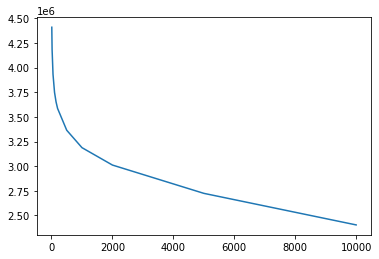

In [ ]:
plt.plot(cluster_sizes, ssd)

In [ ]:
n_clusters = 1000

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=n_clusters).fit(user_embs)
kmeans.labels_

array([ 89,  15, 220, ..., 493, 104,  86], dtype=int32)

In [ ]:
print(np.histogram(kmeans.labels_, bins=20))

(array([5911, 5720, 5352, 5918, 5413, 4810, 4705, 4936, 4320, 4740, 4711,
       5406, 4838, 4486, 4400, 4181, 4298, 4311, 4254, 4523]), array([  0.  ,  49.95,  99.9 , 149.85, 199.8 , 249.75, 299.7 , 349.65,
       399.6 , 449.55, 499.5 , 549.45, 599.4 , 649.35, 699.3 , 749.25,
       799.2 , 849.15, 899.1 , 949.05, 999.  ]))


In [ ]:
kmeans.cluster_centers_

array([[-0.55388075, -0.03160688,  1.1516001 , ..., -0.23080535,
        -0.42420956, -0.22103257],
       [-0.15448466, -0.76033527, -0.10164347, ...,  0.9592681 ,
        -0.3265443 ,  0.19375402],
       [-0.14779067, -0.84787697, -0.30765805, ...,  0.8550373 ,
         0.1111447 ,  0.8669913 ],
       ...,
       [ 0.29968092, -0.89609957, -1.5683019 , ...,  0.7103771 ,
        -0.4938326 , -0.18194115],
       [-0.16549657, -1.2329925 ,  0.1927891 , ..., -1.0756308 ,
        -0.7662767 , -0.09816051],
       [-0.60798025, -0.02336087,  0.1487505 , ..., -0.7299217 ,
        -0.30159888, -0.12653391]], dtype=float32)

In [ ]:
norm = torch.norm(torch.tensor(kmeans.cluster_centers_), dim=1)
print(np.histogram(norm, bins=20))

(array([ 14,  66, 138, 167, 174, 127,  89,  83,  48,  34,  17,  15,  11,
         6,   4,   2,   3,   0,   1,   1]), array([ 2.5297244,  3.1154573,  3.7011905,  4.2869234,  4.8726563,
        5.4583893,  6.0441227,  6.6298556,  7.2155886,  7.8013215,
        8.387054 ,  8.972788 ,  9.55852  , 10.144254 , 10.729986 ,
       11.31572  , 11.901453 , 12.4871855, 13.072919 , 13.658651 ,
       14.244385 ], dtype=float32))


In [ ]:
!unzip movie_workflow_genres_avgrating
workflow = nvt.Workflow.load('movie_workflow_genres_avgrating')
# workflow = nvt.Workflow.load('movie_workflow_nopop_genres_avgrating')

Archive:  movie_workflow_genres_avgrating.zip
   creating: movie_workflow_genres_avgrating/
  inflating: movie_workflow_genres_avgrating/workflow.pkl  
  inflating: movie_workflow_genres_avgrating/metadata.json  
   creating: movie_workflow_genres_avgrating/categories/
  inflating: movie_workflow_genres_avgrating/categories/unique.userId.parquet  
  inflating: movie_workflow_genres_avgrating/categories/unique.movieId.parquet  
  inflating: movie_workflow_genres_avgrating/categories/unique.split_genres.parquet  


In [ ]:
batch_size = 1024

# File is too large so we partition into 10 datasets to fit
for i in range(10):
    if i < 9:
        ds = nvt.Dataset(df_ratings.iloc[i*(len(df_ratings)//10):(i+1)*(len(df_ratings)//10)])
    else:
        ds = nvt.Dataset(df_ratings.iloc[i*(len(df_ratings)//10):])
    workflow.fit(ds)

# File is too large so we partition into 10 datasets to transform
for i in range(10):
    if i < 9:
        ds = nvt.Dataset(df_ratings.iloc[i*(len(df_ratings)//10):(i+1)*(len(df_ratings)//10)])
    else:
        ds = nvt.Dataset(df_ratings.iloc[i*(len(df_ratings)//10):])
    workflow.transform(ds).to_parquet('ds_{}'.format(i))

dls = []
for i in range(10):
    torch_ds = TorchAsyncItr(
        nvt.Dataset('ds_{}'.format(i), engine='parquet'),
        batch_size=batch_size,
        cats=['userId', 'movieId', 'split_genres'],
        conts=["rating", 'avg_rating', 'num_ratings'], 
    )
    dl = DLDataLoader(
        torch_ds, batch_size=None, pin_memory=False, num_workers=0
    )
    dls.append(dl)

In [ ]:
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
n_users = cat_emb_shape['userId'][0]
n_media = cat_emb_shape['movieId'][0]

ratings = np.zeros((n_clusters, n_media))
counts = np.zeros((n_clusters, n_media))

for dl in dls:
    for x, _ in dl:
        user = x['userId'].numpy().squeeze()
        cluster = kmeans.labels_[user]
        media = x['movieId'].numpy().squeeze()
        y = x['rating'].numpy().squeeze()
        
        for i in range(len(user)):
            if user[i] == 0: continue
            ratings[cluster[i], media[i]] += y[i]
            counts[cluster[i], media[i]] += 1.

ratings *= 5

In [ ]:
ratings /= counts
ratings[np.isnan(ratings)] = 0.

<ipython-input-24-caeec7312dcf>:1: RuntimeWarning: invalid value encountered in true_divide
  ratings /= counts


In [ ]:
np.save('cluster_ratings_1000--02_02_23', ratings)
np.save('cluster_centroids_1000--02_02_23', kmeans.cluster_centers_)

In [ ]:
def get_workflow_ratings_vector(user_ratings, n_media):
    ''' Computes the ratings vector from original ratings for use in clustering.

    Args:
      user_ratings: [{'movieId': int, 'rating': float}]
      n_media: int. Length of rating vectors in clusters
    '''
    ratings_vector = np.zeros(n_media)
    movie_ids = [r['movieId'] for r in user_ratings]
    movie_ratings = [r['rating'] for r in user_ratings]
    df = pd.DataFrame({'userId': [0]*len(movie_ids), 'movieId': movie_ids, 'rating': movie_ratings})
    # Throw away values for join
    df_movies = pd.DataFrame({'movieId': movie_ids, 
                              'split_genres': [["Adventure", "Animation"]]*len(movie_ids), 
                              'num_ratings': [0]*len(movie_ids),
                              'avg_rating': [3.0]*len(movie_ids)})

    ds = nvt.Dataset(df)
    torch_ds = TorchAsyncItr(
        workflow.transform(ds),
        batch_size=1,
        cats=['userId', 'movieId', 'split_genres'],
        conts=["rating", 'avg_rating', 'num_ratings'], 
    )
    dl = DLDataLoader(torch_ds, batch_size=None, pin_memory=False, num_workers=0)
    for x, _ in dl:
        media = x['movieId']
        y = x['rating']
        ratings_vector[media] = y*5
    
    return ratings_vector
    

def find_closest_cluster(user_ratings, cluster_ratings):
    diff = np.linalg.norm(cluster_ratings*(user_ratings>0) - user_ratings, axis=1)
    cluster = np.argmin(diff)
    return cluster

In [ ]:
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
n_media = cat_emb_shape['movieId'][0]
# r = [{'movieId': 858, 'rating': 5.}, {'movieId': 2028, 'rating': 5.}, 
#      {'movieId': 296, 'rating': 5.}, {'movieId': 3578, 'rating': 5.}]
r = [{'movieId': 1721, 'rating': 5.}, {'movieId': 1265, 'rating': 4.}, 
     {'movieId': 1197, 'rating': 5.}]

ratings_vector = get_workflow_ratings_vector(r, n_media)
cluster = find_closest_cluster(ratings_vector, np.load('cluster_ratings.npy'))

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


[2.47483045 2.71455696 1.31619486 1.96018637 1.80717977 1.64749587
 2.1961146  2.90950301 2.74732014 4.22308871 2.86740217 1.54032659
 1.70993812 1.24933405 1.90556724 0.93365325 2.50786645 1.49360581
 4.08563911 2.51738737 1.46503286 2.42325    1.18067159 3.15033146
 1.93207535 1.61742169 2.32026395 1.4348003  2.07314348 1.33140109
 2.71576965 0.99047863 1.45526455 2.024105   2.1534526  3.13786629
 1.56184663 2.34157773 2.71107739 2.37811166 2.85583068 1.47409684
 2.25385944 3.57349533 2.06330298 1.26947487 1.63396602 1.34315965
 1.70346825 2.84049119 1.75916458 1.52214187 2.57021718 0.8549567
 2.68304462 1.93076843 2.14993056 1.90399819 3.02933526 1.67266705
 2.26307609 0.99995003 2.10121346 1.63230118 2.54179835 2.83576062
 2.31903047 1.824231   1.56439308 2.33788755 2.21792366 2.43030837
 2.3137525  1.5236189  2.06025369 3.64640006 1.56172582 2.64812447
 3.44476889 2.10949855 3.0085252  1.46644577 1.879134   3.54543277
 2.32739817 3.93353224 3.45334601 1.91656976 2.40264168 1.89585

In [ ]:
cluster_ratings = np.load('cluster_ratings.npy')

In [ ]:
# (cluster_ratings*(ratings_vector>0))[cluster][cluster_ratings[cluster] * ratings_vector > 0]
cluster_ratings[cluster][cluster_ratings[cluster] * ratings_vector > 0]

array([4.23907324, 4.34294875, 4.57975542])

In [ ]:
cluster

53

In [ ]:
# Can't reassign to torchscript models so load state dict from ts model into new model
ts_model = model
emb_size, hidden_dim = 32, 128
cat_emb_shape, genre_emb_shape = nvt.ops.get_embedding_sizes(workflow)
model = MLPGenreMH(emb_size, hidden_dim, 
                   genre_emb_shape['split_genres'], 
                   n_users=cat_emb_shape['userId'][0], 
                   n_media=cat_emb_shape['movieId'][0],
                   n_extra_feats=2)
model.load_state_dict(ts_model.state_dict())

<All keys matched successfully>

In [ ]:
# Concatenate default (avg) with clusters
default_user_emb = extract_prod_user_emb(model.user_emb.weight.detach(), None)
centroids = torch.tensor(np.load('cluster_centroids.npy'))

test_model = prodMLPGenresMH(model, torch.cat([default_user_emb, centroids], axis=0), model.media_emb.weight.detach())

In [ ]:
# Create DL to test specific user
movie_ids = np.unique(df_ratings['movieId'])
user_df = pd.DataFrame({'userId': [0]*len(movie_ids), 'movieId': movie_ids, 'rating': [0.]*len(movie_ids)})

user_ds = nvt.Dataset(user_df)

torch_ds = TorchAsyncItr(
    workflow.transform(user_ds),
    batch_size=1024,
    cats=['userId', 'movieId', 'split_genres'],
    conts=["rating", 'avg_rating', 'num_ratings'], 
)
dl = DLDataLoader(torch_ds, batch_size=None, pin_memory=False, num_workers=0)

/usr/local/lib/python3.8/dist-packages/merlin/io/dataset.py:253: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [ ]:
preds = []

# model.cuda()
model.eval()
for i, (x, _) in enumerate(dl):
    user = x['userId'] #.to('cuda')
    user += cluster +  1
    media = x['movieId'] #.to('cuda')
    genres = [x['split_genres'][0], #.to('cuda'),
              x['split_genres'][1]] #.to('cuda')]
    extra_feats = [x['avg_rating'], #.to('cuda'), 
                   x['num_ratings']] #.to('cuda')]

    with torch.no_grad():
        pred = model(user, media, genres, extra_feats)
        pred = pred.squeeze().cpu()
        preds.extend(pred)

print(sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)[:5])

sorted_preds = sorted(zip(preds, movie_ids), key=lambda x: x[0], reverse=True)

[(tensor(0.9686), 149879), (tensor(0.9686), 166231), (tensor(0.9686), 179625), (tensor(0.9686), 179627), (tensor(0.9686), 179629)]


In [ ]:
tmp_genres = next(iter(dl))[0]['split_genres']

model.to('cpu')
model.eval()

inp = (torch.zeros((1024,1), dtype=int), 
       torch.randint(1, 10000, (1024,1)),
       [tmp_genres[0], tmp_genres[1]],
       [torch.rand((1024,1)), torch.rand((1024,1))],)
traced_model = torch.jit.trace(model, inp)
traced_model.save('mlpgenre_cluster_4l128_32emb_1e-2lradam_0d_5e--02_02_23.pt')